In [ ]:
from collections import Counter, defaultdict
from itertools import combinations
import pandas as pd
import numpy as np
import operator
import math
import itertools
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing, tree
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

2023-12-11 02:15:17.693395: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 02:15:17.817952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-11 02:15:17.818000: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-11 02:15:17.848440: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 02:15:20.160424: W tensorflow/stream_executor/platform/de

# Thank you Sandya

In [ ]:
## Loading Datasets & Preprocessing

def preprocess(df, value):
    ## only want years 2011-2012
    # except for 2016
    required_columns = ['Province'] + [str(year) for year in range(2011, 2022) if (str(year) in df.columns) and year != 2016]
    filtered_df = df[required_columns]

    ## make it 1 row = 1 province at 1 year instead of 1 province
    melted_df = pd.melt(filtered_df, id_vars='Province', var_name='Year', value_name=value)

    ## making the datatype easy to work with
    # year object to datetime
    melted_df['Year'] = pd.to_datetime(melted_df['Year'], format='%Y')

    melted_df['Year'] = melted_df['Year'].apply(lambda x: x.year)

    # some rows have - as a value which cannot be converted to float, so turn to nan first
    melted_df[value] = pd.to_numeric(melted_df[value].replace('-', pd.NA), errors='coerce')

    return melted_df

target datasets

In [ ]:
# be mindful that this dataset does not have 2016 year
energy_consumption = pd.read_csv("/work/Energy Consumption.csv")
energy_consumption = preprocess(energy_consumption, 'energy_consumption')
energy_consumption

,Province,Year,energy_consumption
0,ACEH,2011,1579.77
1,SUMATERA UTARA,2011,7194.03
2,SUMATERA BARAT,2011,2403.10
3,RIAU,2011,2361.15
4,JAMBI,2011,1054.17
...,...,...,...
345,MALUKU,2021,582.88
346,MALUKU UTARA,2021,637.04
347,PAPUA BARAT,2021,583.21
348,PAPUA,2021,1237.64


In [ ]:
energy_generation = pd.read_csv("/work/Energy Generation.csv")
energy_generation = preprocess(energy_generation, 'energy_generation')
energy_generation

,Province,Year,energy_generation
0,ACEH,2011,1579.77
1,SUMATERA UTARA,2011,7194.03
2,SUMATERA BARAT,2011,2403.10
3,RIAU,2011,2361.15
4,JAMBI,2011,1054.17
...,...,...,...
345,MALUKU,2021,969.89
346,MALUKU UTARA,2021,377.04
347,PAPUA BARAT,2021,677.34
348,PAPUA,2021,1360.61


In [ ]:
energy_capacity = pd.read_csv("/work/Energy Capacity.csv")
energy_capacity = preprocess(energy_capacity, 'energy_capacity')
energy_capacity

,Province,Year,energy_capacity
0,ACEH,2011,159.26
1,SUMATERA UTARA,2011,2450.67
2,SUMATERA BARAT,2011,33.45
3,RIAU,2011,111.23
4,JAMBI,2011,12.82
...,...,...,...
345,MALUKU,2021,390.74
346,MALUKU UTARA,2021,157.88
347,PAPUA BARAT,2021,267.51
348,PAPUA,2021,525.64


features

socioeconomic

In [ ]:
homeowners = pd.read_csv("/work/Homeowners.csv")
homeowners.drop([35,36,37,38], inplace=True) # delete subtext
homeowners = preprocess(homeowners, 'prop_homeowners')
homeowners

,Province,Year,prop_homeowners
0,ACEH,2011,79.02
1,SUMATERA UTARA,2011,66.07
2,SUMATERA BARAT,2011,69.51
3,RIAU,2011,68.42
4,JAMBI,2011,78.02
...,...,...,...
345,MALUKU,2021,75.13
346,MALUKU UTARA,2021,83.40
347,PAPUA BARAT,2021,76.03
348,PAPUA,2021,83.20


In [ ]:
household_work = pd.read_csv("/work/Household working.csv")
household_work = household_work.rename(columns={'Unnamed: 0': 'Province'})
household_work = preprocess(household_work, 'prop_working')
household_work

,Province,Year,prop_working
0,Aceh,2011,87.13
1,Sumatera Utara,2011,90.28
2,Sumatera Barat,2011,86.66
3,R i a u,2011,91.90
4,J a m b i,2011,90.87
...,...,...,...
345,Maluku,2021,86.18
346,Maluku Utara,2021,89.85
347,Papua Barat,2021,91.64
348,P a p u a,2021,94.32


In [ ]:
school_inattend = pd.read_csv("/work/School Inattendance.csv")
school_inattend = preprocess(school_inattend, 'prop_school_absentees')
school_inattend

,Province,Year,prop_school_absentees
0,Aceh,2011,3.17
1,Sumatera Utara,2011,2.34
2,Sumatera Barat,2011,2.02
3,Riau,2011,2.39
4,Jambi,2011,3.56
...,...,...,...
345,Maluku,2021,2.27
346,Maluku Utara,2021,1.08
347,Papua Barat,2021,3.55
348,Papua,2021,25.55


In [ ]:
toilet_access = pd.read_csv("/work/Toilet Facility Access.csv")
toilet_access.drop([35,36,37,38,39], inplace=True) # delete subtext
toilet_access = preprocess(toilet_access, 'prop_toilet_access')
toilet_access

,Province,Year,prop_toilet_access
0,Aceh,2011,60.34
1,Sumatera Utara,2011,74.88
2,Sumatera Barat,2011,54.65
3,Riau,2011,83.81
4,Jambi,2011,68.12
...,...,...,...
345,Maluku,2021,72.87
346,Maluku Utara,2021,69.73
347,Papua Barat,2021,75.48
348,Papua,2021,63.34


economic

In [ ]:
gdp = pd.read_csv("/work/GDP.csv")
# gdp represented with columns
gdp = gdp.replace(',', '', regex=True)
# then preprocess
gdp = preprocess(gdp, 'gdp')
gdp

,Province,Year,gdp
0,Aceh,2011,108217.63
1,North Sumatra,2011,377037.10
2,West Sumatra,2011,118674.29
3,Riau,2011,485649.34
4,Jambi,2011,103522.91
...,...,...,...
345,Maluku,2021,48564.22
346,North Maluku,2021,52359.85
347,West Papua,2021,85072.86
348,Papua,2021,235343.25


In [ ]:
population = pd.read_csv("/work/Population.csv")
population.drop([35,36,37,38], inplace=True) # delete subtext
population = preprocess(population, 'population')
population

,Province,Year,population
0,Aceh,2012,4715.0
1,Sumatera Utara,2012,13408.0
2,Sumatera Barat,2012,5000.0
3,Riau,2012,5879.0
4,Kep. Riau,2012,3227.0
...,...,...,...
310,Maluku,2021,1862.6
311,Maluku Utara,2021,1299.2
312,Papua Barat,2021,1156.8
313,Papua,2021,4355.5


physical / climate

In [ ]:
# note! missing 2011
land_area = pd.read_csv("/work/Land Area.csv")
# Loop through specified columns, remove spaces
columns_to_convert = [str(year) for year in range(2012, 2022)]
for column_name in columns_to_convert:
    land_area[column_name] = land_area[column_name].str.replace(' ', '')

land_area = preprocess(land_area, 'land_area')
land_area

,Province,Year,land_area
0,Aceh,2012,57956.00
1,Sumatera Utara,2012,72981.23
2,Sumatera Barat,2012,42012.89
3,Riau,2012,87023.66
4,Kepulauan Riau,2012,8201.72
...,...,...,...
310,Maluku,2021,46914.03
311,Maluku Utara,2021,31982.50
312,Papua,2021,319036.05
313,Papua Barat,2021,99671.63


In [ ]:
# note! missing 2016, 2017, 2018, 2019, 2020, 2021
rainy_days = pd.read_csv("/work/Rainy Days.csv")
rainy_days = preprocess(rainy_days, 'num_rainy_days')
rainy_days

,Province,Year,num_rainy_days
0,Aceh,2011,150.0
1,Sumatera Utara,2011,225.0
2,Sumatera Barat,2011,NaN
3,Riau,2011,211.0
4,Jambi,2011,209.0
...,...,...,...
165,Sulawesi Barat,2015,93.0
166,Maluku,2015,167.0
167,Maluku Utara,2015,127.0
168,Papua Barat,2015,218.0


Combine to create final dataframe

In [ ]:
dfs_list = [energy_consumption, energy_generation, energy_capacity, homeowners, household_work, school_inattend, toilet_access,gdp, population, land_area]  # Add all your datasets here
combined_df = pd.concat(dfs_list, axis=1)
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]
combined_df

,Province,Year,energy_consumption,energy_generation,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011,1579.77,1579.77,159.26,79.02,87.13,3.17,60.34,108217.63,4715.0,57956.00
1,SUMATERA UTARA,2011,7194.03,7194.03,2450.67,66.07,90.28,2.34,74.88,377037.10,13408.0,72981.23
2,SUMATERA BARAT,2011,2403.10,2403.10,33.45,69.51,86.66,2.02,54.65,118674.29,5000.0,42012.89
3,RIAU,2011,2361.15,2361.15,111.23,68.42,91.90,2.39,83.81,485649.34,5879.0,87023.66
4,JAMBI,2011,1054.17,1054.17,12.82,78.02,90.87,3.56,68.12,103522.91,3227.0,8201.72
...,...,...,...,...,...,...,...,...,...,...,...,...
345,MALUKU,2021,582.88,969.89,390.74,75.13,86.18,2.27,72.87,48564.22,NaN,NaN
346,MALUKU UTARA,2021,637.04,377.04,157.88,83.40,89.85,1.08,69.73,52359.85,NaN,NaN
347,PAPUA BARAT,2021,583.21,677.34,267.51,76.03,91.64,3.55,75.48,85072.86,NaN,NaN
348,PAPUA,2021,1237.64,1360.61,525.64,83.20,94.32,25.55,63.34,235343.25,NaN,NaN


note! all target datasets are missing year 2016 so energy_consumption, energy_generation, energy_capacity in that year are nans (we have 35 nan values for all target variables) -- this is also shown in how even if all datasets go through the same preprocessing function, these 3 datasets have 350 rows and all other datasets have 385 rows should be good

# Ethan Edits

## Notes

Edits: 
- made year just the year rather than like a timestamp
- got rid of all rows with year of 2016

Need to change it to look like the example df; 
2011 features with 2014 target variable 
-->
2018 features with 2021 target variable 

therefore, we don't need any data after 2018

## Feature_df: Generation and Description

In [ ]:
drop_post_2019 = combined_df[combined_df['Year'] < 2019]
feature_df = drop_post_2019.drop(['energy_consumption', 'energy_generation', 'energy_capacity'], axis=1)
feature_df

,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4715.0,57956.00
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13408.0,72981.23
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,5000.0,42012.89
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5879.0,87023.66
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3227.0,8201.72
...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1768.5,46914.03
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1235.7,31982.50
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,963.6,319036.05
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3347.1,99671.63


In [ ]:
count = 0
for col in feature_df.columns:
    num_nans = feature_df[col].isna().sum()
    count += num_nans
    print(col + ': ' + str(num_nans))
print(count)

Province: 0
Year: 0
prop_homeowners: 4
prop_working: 4
prop_school_absentees: 4
prop_toilet_access: 4
gdp: 2
population: 5
land_area: 1
24


## Add Target(s) to feature_df

In [ ]:
def add_target_to_feature_df(feature_df, target_df, target_name):
    full_df = feature_df.copy()
    clean_target = target_df[target_df['Year'] >= 2014].reset_index()
    full_df['target: ' + target_name] = clean_target[target_name]

    print('num nans in target col: ' + str(clean_target[target_name].isna().sum()))

    return full_df

In [ ]:
ecap_df = add_target_to_feature_df(feature_df, energy_capacity, 'energy_capacity')
ecap_df

num nans in target col: 4


,Province,Year,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,target: energy_capacity
0,ACEH,2011,79.02,87.13,3.17,60.34,108217.63,4715.0,57956.00,201.25
1,SUMATERA UTARA,2011,66.07,90.28,2.34,74.88,377037.10,13408.0,72981.23,4116.45
2,SUMATERA BARAT,2011,69.51,86.66,2.02,54.65,118674.29,5000.0,42012.89,72.67
3,RIAU,2011,68.42,91.90,2.39,83.81,485649.34,5879.0,87023.66,172.62
4,JAMBI,2011,78.02,90.87,3.56,68.12,103522.91,3227.0,8201.72,51.54
...,...,...,...,...,...,...,...,...,...,...
240,MALUKU,2018,80.09,87.44,1.13,68.02,43047.09,1768.5,46914.03,390.74
241,MALUKU UTARA,2018,83.87,91.15,1.55,61.98,36468.79,1235.7,31982.50,157.88
242,PAPUA BARAT,2018,69.19,90.43,3.11,72.03,79644.58,963.6,319036.05,267.51
243,PAPUA,2018,81.36,94.73,26.46,57.53,210600.57,3347.1,99671.63,525.64


# Modeling

## Sklearn Linear Regression

In [ ]:
pq2_df = ecap_df.copy().drop(['Province', 'Year'], axis=1).dropna()
X = pq2_df.drop('target: energy_capacity', axis=1)
y = pq2_df['target: energy_capacity']

ecap_X_train, ecap_X_test, ecap_y_train, ecap_y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:


test_size = [.15, .20, .25, .30]
mses = []
r_squareds = []
for i in test_size:
    ecap_X_train, ecap_X_test, ecap_y_train, ecap_y_test = train_test_split(X, y, test_size = i, random_state = 42)
    lr = LinearRegression()
    lr.fit(ecap_X_train, ecap_y_train)
    ecap_y_pred = lr.predict(ecap_X_test)
    mses.append(mean_squared_error(ecap_y_test, ecap_y_pred, squared = False))
    r_squareds.append(r2_score(ecap_y_test, ecap_y_pred))
r_squareds
df = pd.DataFrame(data = np.array(mses, r_squareds)],  
                   index = ["mse", "r_squared"],  
                   columns = test_size) 




# sns.scatterplot(x = egen_y_test, y = egen_y_pred)

SyntaxError: invalid syntax (2305341435.py, line 12)

Our r squared for the linear regression model when testing size = 0.25 is really high (r^2 = 0.9451982816276415); this could indicate overfitting on the training set. 

When our testing size is 0.15, the r squared val

## Ridge Regression

opted for Ridge over Lasso because Ridge regression can handle correlated features and Lasso cannot; our data currently (as of 12/8) has correlated features, but this can change so maybe will switch to Lasso in the future

## LSTM (long short term memory)

Since we are doing a time series prediction, we wanted to use a type of recursive neural network called Long Short Term Memory to do regression 

In [ ]:
# for lstm model, no need df to have target year as can handle that in lookback period parameter
df = combined_df.drop(['energy_consumption', 'energy_generation'], axis=1)
indo_df = df[df['Province']=='INDONESIA']
indo_df

,Province,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area
34,INDONESIA,2011,35596.74,79.22,88.36,5.72,65.20,7825075.53,245416.0,1910931.32
69,INDONESIA,2012,44841.54,80.89,88.50,5.24,66.53,8672954.41,248818.0,1910931.32
104,INDONESIA,2013,45476.31,80.08,88.21,5.16,69.71,9612506.50,252165.0,1910931.32
139,INDONESIA,2014,53015.70,79.77,88.34,4.87,71.52,10699877.63,255462.0,1913578.68
174,INDONESIA,2015,54400.17,82.63,88.10,5.25,74.34,11526332.80,261891.0,1913578.68
209,INDONESIA,2017,58163.33,79.61,87.06,4.15,77.84,13589825.70,264161.6,1913578.68
244,INDONESIA,2018,63746.79,80.02,86.85,3.96,79.35,14838756.00,266911.9,1913578.68
279,INDONESIA,2019,64842.53,80.07,87.07,3.57,81.13,15832657.20,270203.9,1913578.68
314,INDONESIA,2020,65235.81,80.10,86.66,3.19,82.86,15438017.50,272682.5,1913578.68
349,INDONESIA,2021,66514.31,81.08,87.72,3.01,85.51,16970789.20,NaN,NaN


In [ ]:
# normalize data
scaler = MinMaxScaler(feature_range=(0,1))
indo_df['scaled_values'] = scaler.fit_transform(indo_df['energy_capacity'].values.reshape(-1,1))
indo_df

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Province,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,scaled_values
34,INDONESIA,2011,35596.74,79.22,88.36,5.72,65.20,7825075.53,245416.0,1910931.32,0.000000
69,INDONESIA,2012,44841.54,80.89,88.50,5.24,66.53,8672954.41,248818.0,1910931.32,0.299014
104,INDONESIA,2013,45476.31,80.08,88.21,5.16,69.71,9612506.50,252165.0,1910931.32,0.319545
139,INDONESIA,2014,53015.70,79.77,88.34,4.87,71.52,10699877.63,255462.0,1913578.68,0.563400
174,INDONESIA,2015,54400.17,82.63,88.10,5.25,74.34,11526332.80,261891.0,1913578.68,0.608179
209,INDONESIA,2017,58163.33,79.61,87.06,4.15,77.84,13589825.70,264161.6,1913578.68,0.729895
244,INDONESIA,2018,63746.79,80.02,86.85,3.96,79.35,14838756.00,266911.9,1913578.68,0.910487
279,INDONESIA,2019,64842.53,80.07,87.07,3.57,81.13,15832657.20,270203.9,1913578.68,0.945928
314,INDONESIA,2020,65235.81,80.10,86.66,3.19,82.86,15438017.50,272682.5,1913578.68,0.958648
349,INDONESIA,2021,66514.31,81.08,87.72,3.01,85.51,16970789.20,NaN,NaN,1.000000


In [ ]:
# just imputing nans in 2021's population and land area
indo_df.loc[349, 'population'] = 273753191
indo_df.loc[349, 'land_area'] = 1913578.68 # same as 2020's
indo_df

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Province,Year,energy_capacity,prop_homeowners,prop_working,prop_school_absentees,prop_toilet_access,gdp,population,land_area,scaled_values
34,INDONESIA,2011,35596.74,79.22,88.36,5.72,65.20,7825075.53,245416.0,1910931.32,0.000000
69,INDONESIA,2012,44841.54,80.89,88.50,5.24,66.53,8672954.41,248818.0,1910931.32,0.299014
104,INDONESIA,2013,45476.31,80.08,88.21,5.16,69.71,9612506.50,252165.0,1910931.32,0.319545
139,INDONESIA,2014,53015.70,79.77,88.34,4.87,71.52,10699877.63,255462.0,1913578.68,0.563400
174,INDONESIA,2015,54400.17,82.63,88.10,5.25,74.34,11526332.80,261891.0,1913578.68,0.608179
209,INDONESIA,2017,58163.33,79.61,87.06,4.15,77.84,13589825.70,264161.6,1913578.68,0.729895
244,INDONESIA,2018,63746.79,80.02,86.85,3.96,79.35,14838756.00,266911.9,1913578.68,0.910487
279,INDONESIA,2019,64842.53,80.07,87.07,3.57,81.13,15832657.20,270203.9,1913578.68,0.945928
314,INDONESIA,2020,65235.81,80.10,86.66,3.19,82.86,15438017.50,272682.5,1913578.68,0.958648
349,INDONESIA,2021,66514.31,81.08,87.72,3.01,85.51,16970789.20,273753191.0,1913578.68,1.000000


### 1. Split into train & test

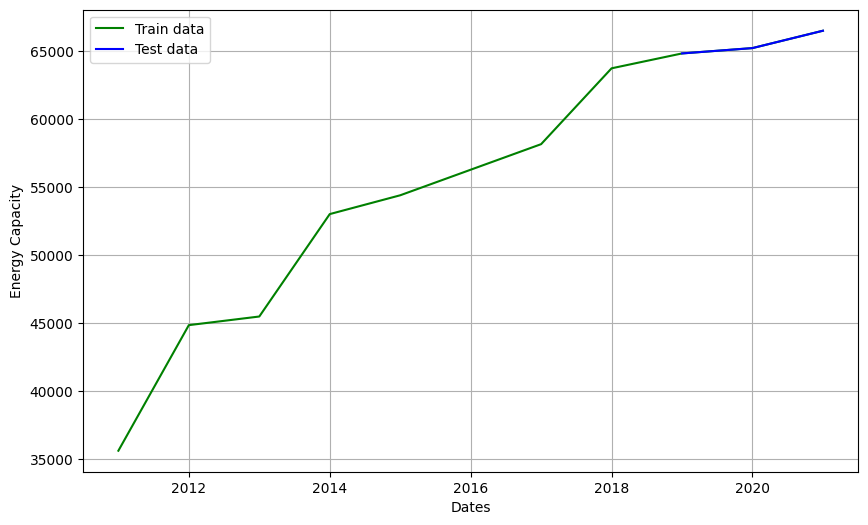

In [ ]:
# split data into train and training set
train_data = indo_df[indo_df['Year'] < 2019] # can only train using data up until 2018 bc newest data is in 2021
test_data = indo_df[indo_df['Year'] >= 2019]

# plotting the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Energy Capacity')
plt.plot(indo_df['Year'], indo_df['energy_capacity'], 'green', label='Train data')
plt.plot(test_data['Year'], test_data['energy_capacity'], 'blue', label='Test data')
plt.legend()

In [ ]:
x_train = []
y_train = []

# choose 1 year as the lookback period; 2000 to predict 2001, 2001 for 2002, and so on
for i in range(1, len(train_data['scaled_values'])):
    historical_values = train_data['scaled_values'][i-3:i]
    # additional features to historical data
    additional_features = ['prop_homeowners', 'prop_working', 'prop_school_absent', 'prop_toilet_access', 'gdp', 'population', 'land_area']
    additional_feature_values = np.empty((1, len(additional_features)))
    for idx, feature_name in enumerate(additional_features): 
        # gather values for each of the features for the same lookback period
        feature_values = train_data[feature_name][i-3:i]
        additional_feature_values[:, idx] = feature_values
    # combine historical & additional features
    combined_features = np.column_stack((historical_values, additional_feature_values))
    x_train.append(combined_features)

    y_train.append(train_data['scaled_values'][i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

ValueError: could not broadcast input array from shape (0,) into shape (1,)

In [ ]:
x_test = []
y_test = test_data['scaled_values']

for i in range(1, len(test_data['scaled_values'])):
    historical_values = test_data['scaled_values'][i-3:i]
    additional_feature_values = np.empty((1, len(additional_features)))
    for idx, feature_name in enumerate(additional_features): 
        # gather values for each of the features for the same lookback period
        feature_values = test_data[feature_name][i-3:i]
        additional_feature_values[:, idx] = feature_values
    # combine historical & additional features
    combined_features = np.column_stack((historical_values, additional_feature_values))
    x_test.append(combined_features)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

ValueError: could not broadcast input array from shape (0,) into shape (1,)

## ARIMAX

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9a2d3571-826e-4759-814d-0768207fd99f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>